In [ ]:
!git clone -q https://github.com/marius311/muse-wl/
!pip install --upgrade "poetry==1.2.0b2"
!(cd muse-wl && POETRY_VIRTUALENVS_IN_PROJECT=true poetry install)
import sys, os.path as osp
sys.path = [osp.abspath("muse-wl/.venv/lib/python3.7/site-packages")] + sys.path

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight', 'dpi': 90}

In [3]:
import jax
import jax.numpy as jnp
import muse_inference
from muse_inference.jax import JittableJaxMuseProblem, JaxMuseProblem
from muse_inference import MuseResult
import jax_cosmo as jc

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

Check using expected device:

In [4]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


# Defining a model

In [5]:
def make_power_map(pk_fn, N, field_size, zero_freq_val=0.0):
  k = 2*jnp.pi*jnp.fft.fftfreq(N, d=field_size / N)
  kcoords = jnp.meshgrid(k,k)
  k = jnp.sqrt(kcoords[0]**2 + kcoords[1]**2)
  ps_map = pk_fn(k)
  ps_map = ps_map.at[0,0].set(zero_freq_val)
  return ps_map * (N / field_size)**2

def model(N=64,                # number of pixels on the map
          map_size=10,         # map size in deg.
          gal_per_arcmin2=30,   
          sigma_e=0.2):      
    
    pix_area = (map_size * 60 / N)**2 # arcmin2 
    map_size = map_size / 180 * jnp.pi    # radians

    # Sampling cosmology
    omega_c = numpyro.sample('omega_c', dist.Normal(0., 1.0)) * 0.05 + 0.3
    sigma_8 = numpyro.sample('sigma_8', dist.Normal(0., 1.0)) * 0.05 + 0.8
    
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma_8)
    # Creating a given redshift distribution
    pz = jc.redshift.smail_nz(0.5, 2., 1.0)
    tracer = jc.probes.WeakLensing([pz])
    
    # Defining the function that will compute the power spectrum of the field
    # Create an interpolation array for the cls to avoid far too many computations
    ell_tab = jnp.logspace(0, 4.5, 128)
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]
    P = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)
    # Sampling latent variables
    z = numpyro.sample('z', dist.MultivariateNormal(loc=jnp.zeros((N,N)), precision_matrix=jnp.eye(N)))
    # Convolving by the power spectrum
    field = jnp.fft.ifft2(jnp.fft.fft2(z) * 
                          jnp.sqrt(make_power_map(P, N, map_size))).real
    
    # Adding "observational noise"
    x = numpyro.sample('x', dist.Independent(dist.Normal(field, sigma_e/jnp.sqrt(gal_per_arcmin2 * pix_area)), 2))
    
    return x

In [6]:
# Create our fiducial observations
fiducial_model = condition(model, {'omega_c': 0., 'sigma_8': 0.})
sample_map_fiducial = seed(fiducial_model, jax.random.PRNGKey(42))
m_data = sample_map_fiducial()

/home/francois/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4457: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


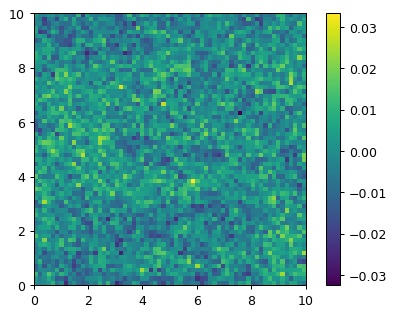

In [7]:
imshow(m_data, extent=(0,10,0,10))
colorbar()

In [8]:
@jax.jit
def log_likelihood(x, z, theta):
  oc = theta[0]
  s8 = theta[1]

  cond_model = condition(model, {'omega_c': oc, 'sigma_8': s8, 'x': x, 
                                 'z': z})
  model_trace = trace(cond_model).get_trace()

  return model_trace['x']['fn'].log_prob(model_trace['x']['value'])

@jax.jit
def log_prior(theta):
  oc = theta[0]
  s8 = theta[1]
  log_prob = dist.Normal(0., 1.).log_prob(oc) + dist.Normal(0., 1.).log_prob(s8) 
  return log_prob

@jax.jit 
def sample(theta, key):
  oc = theta[0]
  s8 = theta[1]
  cond_model = condition(seed(model, key), {'omega_c': oc, 'sigma_8': s8})
  model_trace = trace(cond_model).get_trace()
  return model_trace['x']['value'], model_trace['z']['value']

In [9]:
class LensingProblem(JittableJaxMuseProblem):

    def sample_x_z(self, rng, θ):
        return sample(jnp.array(θ), rng)

    def logLike(self, x, z, θ):
        return log_likelihood(x, z, jnp.array(θ))

    def logPrior(self, θ):
        return log_prior(θ)

In [10]:
θ_true = 0., 0.

In [11]:
prob = LensingProblem()
(x, z) = prob.sample_x_z(jax.random.PRNGKey(0), θ_true)
prob.x = x

# Sanity check

Note: if I decrease to `z_tol=1e-2` or lower, I get a `history.status=4` which means saddle point?? Is this multi-modal? Or perhaps an issue with the phase being periodic?

In [22]:
MAP = prob.z_MAP_and_score(x, z, θ_true, z_tol=2e-2)

In [23]:
MAP.history.success

DeviceArray(True, dtype=bool)

In [24]:
MAP.history.status

DeviceArray(0, dtype=int32, weak_type=True)

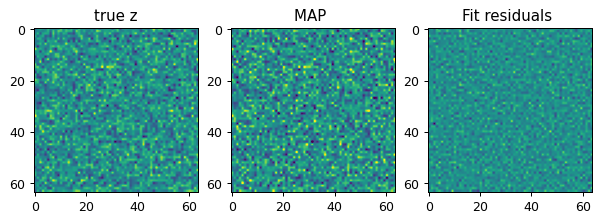

In [30]:
figure(figsize=(8,8))
subplot(131)
imshow(z,vmin=-3, vmax=3);
title("true z")
subplot(132)
imshow(MAP.z,vmin=-3, vmax=3);
title("MAP ")
subplot(133)
imshow(MAP.z - z,vmin=-3, vmax=3)
title("Fit residuals "); 

# Get covariance

Compute the covariance evaluated at the truth, which involves getting the $J$ and $H$ matrices.

In [47]:
result = MuseResult()
result.θ = θ_true;

In [48]:
prob.get_J(
    result, 
    nsims = 100, 
    progress = True, 
    z_tol = 2e-2, 
    rng = jax.random.PRNGKey(0)
);

get_J: 100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.56it/s]


In [49]:
prob.get_H(
    result, 
    θ = θ_true, 
    step = 0.1, 
    nsims = 100, 
    progress = True, 
    z_tol = 2e-2,
    rng = jax.random.PRNGKey(0)
);

get_H: 100%|██████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:29<00:00,  5.57it/s]


Looks like very little extra constraint beyond the prior, is that expected for this small map maybe?:

In [52]:
sqrt(diag(result.Σ)) * 0.05

array([0.02572294, 0.03743673], dtype=float32)

In [56]:
import pickle 
hmc_trace = pickle.load( open( "lensing_fwd_mdl.pickle", "rb" ) )
# Cleanup rejected samples from the trace
inds = np.unique(hmc_trace['omega_c'], return_index=True)[1]

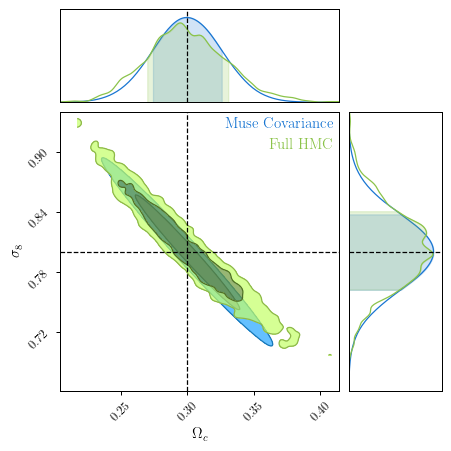

In [80]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_covariance([0.3,0.8] , result.Σ * 0.05**2, 
                 parameters=["$\Omega_c$", "$\sigma_8$"], name="Muse Covariance")

c.add_chain(np.stack([hmc_trace['omega_c'][inds], hmc_trace['sigma_8'][inds]],axis=1)* 0.05 +np.array([0.3,0.8]) , parameters=["$\Omega_c$", "$\sigma_8$"], name='Full HMC')

fig = c.plotter.plot(figsize="column", truth=[0.3,0.8])

# Get estimate

Run the estimate. Not really finding convergence yet.

In [18]:
# Cleaning up the problem
prob = LensingProblem()
prob.x = m_data
# And results
result = MuseResult()

prob.solve(
    result = result, 
    α = 0.2, 
    θ_start = [1.0, -1.], 
    θ_rtol = 0,
    z_tol = 2e-2, 
    progress = True, 
    maxsteps = 50, 
    nsims = 64,
    rng = jax.random.PRNGKey(1)
);

MUSE:   0%|                                                                                                | 0/3250 [00:00<?, ?it/s]/home/francois/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4457: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
MUSE:   2%|█▋                                                                                     | 65/3250 [01:07<14:14,  3.73it/s]/home/francois/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4457: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64

The norm of the MUSE marginal score approximation, i.e. the thing we're trying to zero. This should hopefully descrease until it reaches zero within some tolerance.

(0.0, 2.962316993996501)

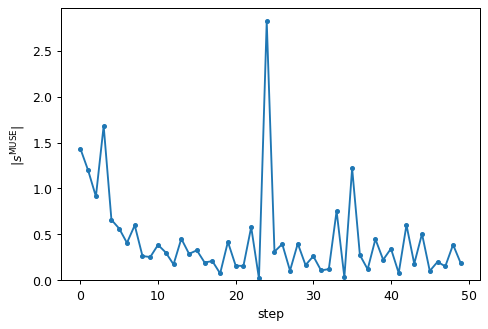

In [19]:
plot([norm(h["s̃_post"]) for h in result.history],".-")
ylabel(r"$|s^{\rm MUSE}|$")
xlabel("step")
ylim(0)

Progression of $\theta$ across steps. Should see this converge to somewhere.


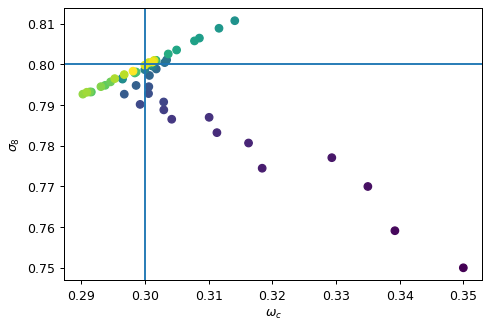

In [20]:
# https://stackoverflow.com/a/66117937
x,y = transpose([h["θ"] for h in result.history]) * 0.05 + jnp.array([0.3,0.8]).reshape([2,1])
plt.scatter(x,y,c=arange(len(x)))
# ds = 0.003
# Ns = np.round(np.sqrt( (x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2 ) / ds).astype(int)
# subdiv = lambda x, Ns=Ns: np.concatenate([ np.linspace(x[ii], x[ii+1], Ns[ii]) for ii, _ in enumerate(x[:-1]) ])
# x, y = subdiv(x), subdiv(y)
# plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, width=.004, headlength=6, headwidth=6)
xlabel(r"$\omega_c$")
ylabel(r"$\sigma_8$")
axvline(0.3)
axhline(0.8)

In [30]:
import pickle 
hmc_trace = pickle.load( open( "lensing_fwd_mdl.pickle", "rb" ) )
# Cleanup rejected samples from the trace
inds = np.unique(hmc_trace['omega_c'], return_index=True)[1]

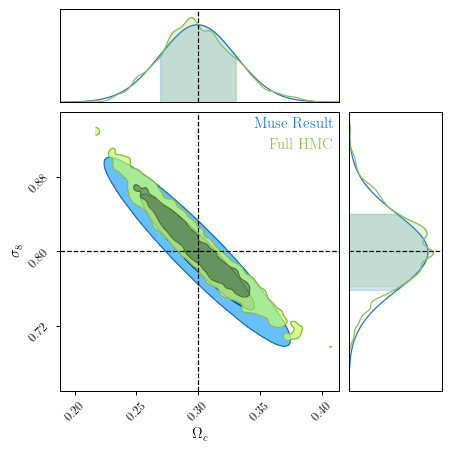

In [31]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_covariance(jnp.stack(result.θ)*0.05 + jnp.array([0.3,0.8]), 
                 result.Σ * 0.05**2, 
                 parameters=["$\Omega_c$", "$\sigma_8$"], name="Muse Result")

c.add_chain(np.stack([hmc_trace['omega_c'][inds], hmc_trace['sigma_8'][inds]],axis=1)* 0.05 +np.array([0.3,0.8]) , parameters=["$\Omega_c$", "$\sigma_8$"], name='Full HMC')

fig = c.plotter.plot(figsize="column", truth=[0.3,0.8])